<p style="font-weight:bold; letter-spacing: 2px; color:#F5F5DC; font-size:140%; text-align:left; max-width: 1050px; padding: 10px; border-bottom: 3px solid #D2B48C"> Decision Tree Classification</p>

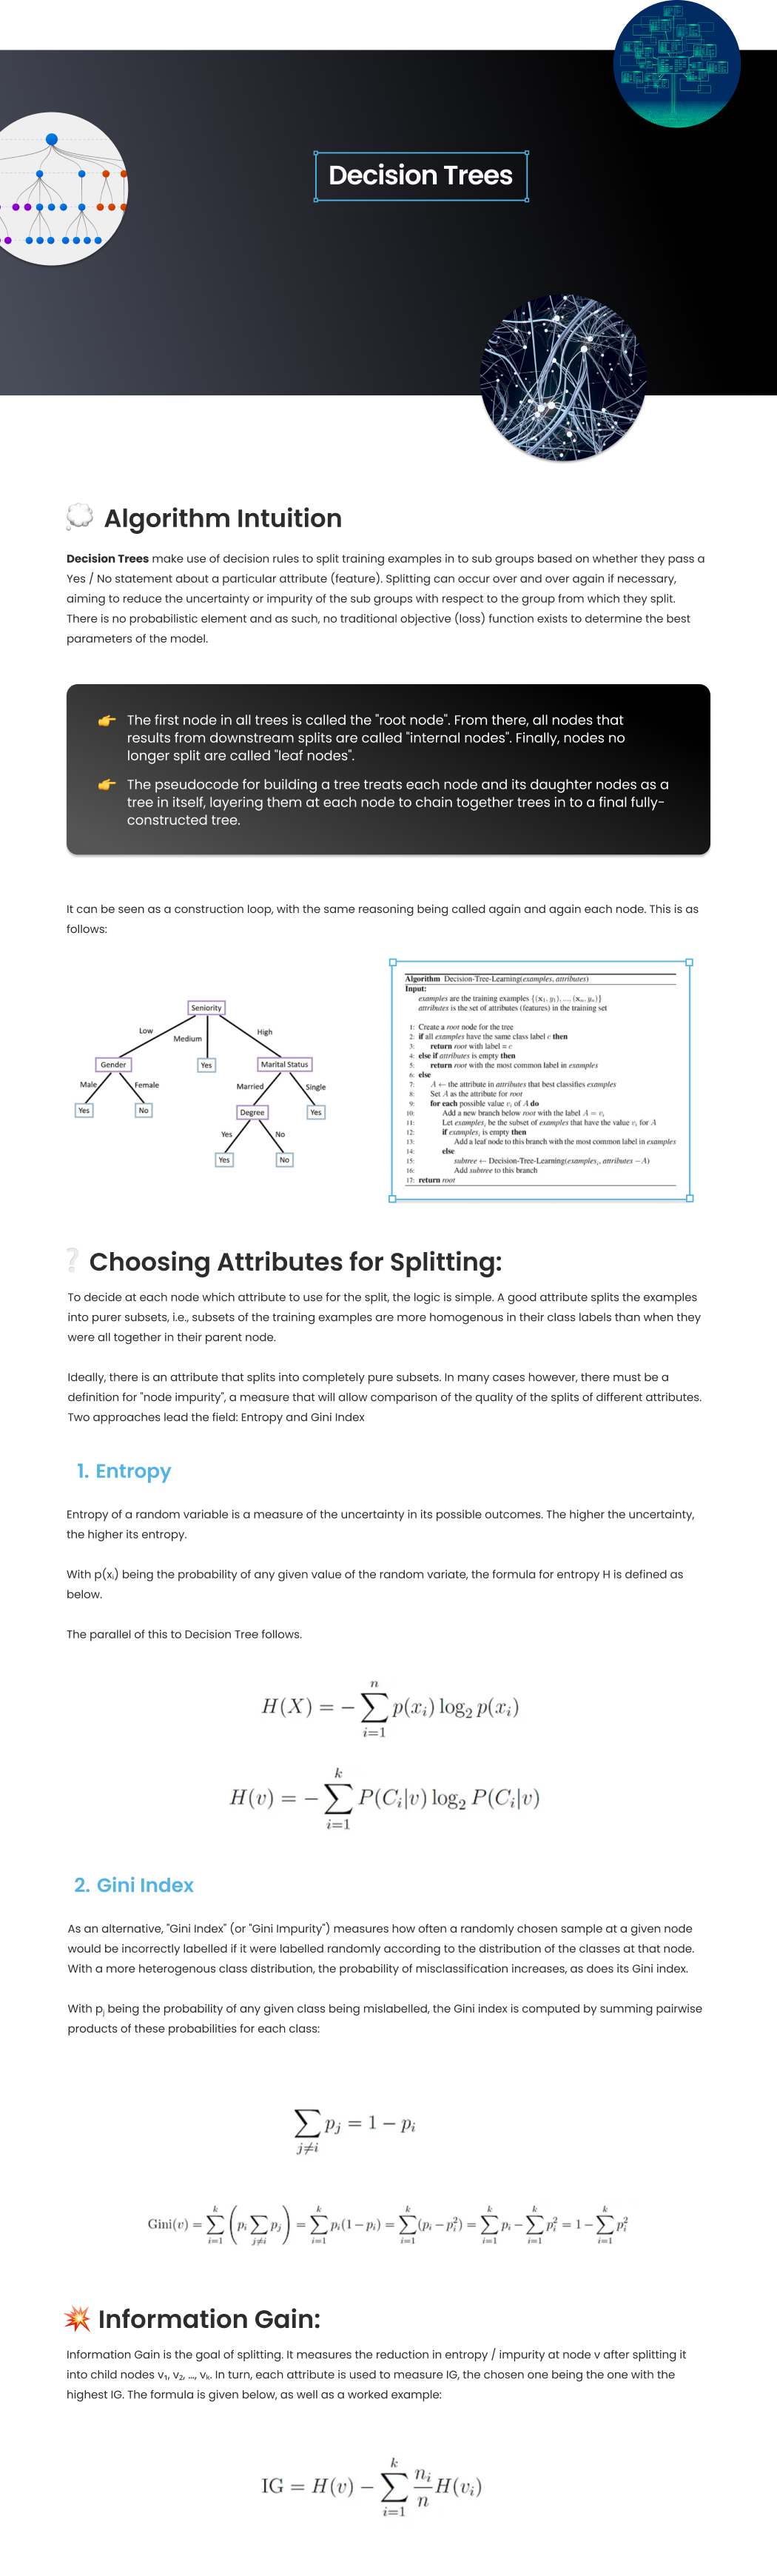

In [60]:
from IPython.display import Image
Image("images\Figma_Decision_Trees.png")

*Approach*
1. Load data
2. Split data
3. Create ColumnTransformer w/ ohe (so scaling needed)
4. Create DecisionTreeClassifier w/ default
5. Create pipeline w/ ColumnTransformer & DecisionTreeClassifier
6. Create and evaluate cross_val_score on pipeline
7. Compare train and test scores for baseline model (overfitting? Train likely ~ 100%)
8. Compare affect of different seeds on baseline model. Verify cross_val_score and test averages are similar
9. Create GridSearchCV with params 
10. Fit and evaluate best hyperparameters
11. Plot classification_report and confusion_matrix
12. Evaluate affect of balancing the class with smote or with class_weight="balanced"
13. Visualise the best performing model with sklearn.tree.plot_tree 
14. Select k most important features and evaluate re-run with just those


*Import Libraries*

In [3]:
# import custom classes, functions and variables. Reload file in to memory on cell excution.
import importlib
import settings
importlib.reload(settings)

# import data frameworks
import pandas as pd
import numpy as np

# import viz
import matplotlib.pyplot as plt
import seaborn as sns

# import ML
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import statsmodels.api as sm
from imblearn.over_sampling import SMOTENC


# import others
import os
import pickle
import warnings

# Specific warning categories to be ignored
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

*Import data from initial EDA*

In [4]:
df = pd.read_csv(os.path.join(settings.DATA_EDA_DIR, settings.DATA_EDA_FILE), sep=",")
if len(df) > 0:
    print("df loaded")

df loaded


*Split data and prepare labels*

In [5]:
ALL_FEATURES = ['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 
                'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate', 
                'Daily Steps', 'Blood Pressure Category']
X = df[ALL_FEATURES]
y = df[settings.LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Encode y vector 
map = {"None":0, "Sleep Apnea":1, "Insomnia":2}
# apply mapping function
settings.column_mapper(y_train, "Sleep Disorder", map)
settings.column_mapper(y_test, "Sleep Disorder", map)

# check new values in consolidated column
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])
# display(settings.examine_values(y_train).loc["Sleep Disorder",:])

# reshape labels to 1-D array (vector) 
y_train, y_test = y_train.values.reshape(-1), y_test.values.reshape(-1)

*Preprocess steps*

In [6]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

*Create pipeline and base model*

In [11]:
# create model
model_dt = DecisionTreeClassifier(random_state=42)  # criterion ='gini' ["gini", "entropy", "log_loss"]
                                                    # splitter = 'best' ["best", "random"]
                                                    # max_depth = None [int]
                                                    # min_samples_split = 2 [int or float]
                                                    # min_samples_leaf = 1 [int or float]
                                                    # min_weight_fraction_leaf = 0.0 [float]
                                                    # max_features = None [int or float or "auto", "sqrt", "log2"]
                                                    # --> random_state = None
                                                    # max_leaf_nodes = None [int]
                                                    # min_impurity_decrease = 0.0 [float]
                                                    # class_weight = None [dict, list of dict or "balanced"]
                                                    # ccp_alpha = 0.0 [float]

# create sklearn pipeline
pipeline_dt = settings.create_pipeline(["preprocess", column_trans], ["decision_tree_classification", model_dt])

# create cross validation object for cross_val_score
cv_dt = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

# define custom scorer for this work: positive label (class 1 and 2) F1 score
base_scorer = settings.CustomPositiveF1Scorer().scorer_function
custom_scorer = settings.CustomPositiveF1Scorer().custom_scorer

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_dt, X_train, y_train, scoring=custom_scorer, cv=cv_dt)

settings.cross_val_summary(pipeline_dt, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)


Train Score: 90.141 %
Mean CV Train Score: 79.7832 % ( +- 6.679 % )
Test Score: 81.250 %



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97        66
           1       0.79      0.79      0.79        24
           2       0.80      0.87      0.83        23

    accuracy                           0.90       113
   macro avg       0.86      0.87      0.86       113
weighted avg       0.91      0.90      0.90       113



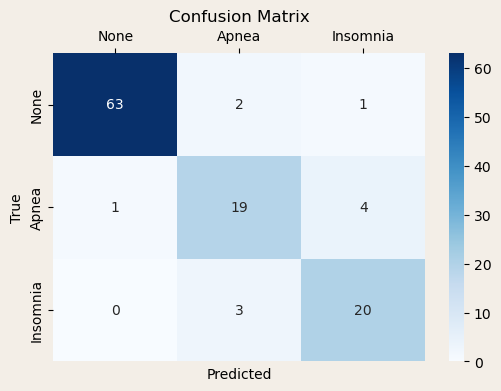

In [12]:
pipeline_dt.fit(X_train, y_train)

# Generate prediction and show classification report
y_pred = pipeline_dt.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Decent baseline cross validated F1 score 79.8% and slightly higher test accuracy 81.2%. Both far below train accuracy at 90.1%: sign of overfitting.</li>
    <li>High variation in cross validated scores (6.7%)</li>
    <li>Overall model accuracy is high at ~ 90%.</li>
    <li>The model is struggling more than others to separate the positive classes at the baseline stage: model making more mistakes at misclassifying Apnea as Insmonia for the first time. Let's see if tuning can move some of the misclassifications in to their correct label (recall) without comprimising (class accuracy) precisoin further.
</ul>
</div>


In [33]:
# Save baseline pipeline to file  
settings.save_pipeline("best_decision_tree_classification_pipeline.pkl", pipeline_dt)

*Hyperparam tuning*

*Impurity and split method*

In [13]:
# set up param grid
param_grid_dt = {
    'decision_tree_classification__criterion': ["gini", "entropy"],
    'decision_tree_classification__splitter': ["best", "random"], 
}

# Create and fit GridSearchCV object on train data
grid_search_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, scoring=custom_scorer, cv=cv_dt, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_dt, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,decision_tree_classification__criterion,decision_tree_classification__splitter
0,gini,random


---------------------
Using best parameters
---------------------
Train Score: 90.141 %
Mean CV Train Score: 80.459 % ( +- 6.430 % )
Test Score: 81.250 %


In [17]:
# Access the grid search results
results = grid_search_dt.cv_results_

# Extract k values, weights values and accuracy scores
grouped = pd.DataFrame(results)
grouped = grouped.groupby(["param_decision_tree_classification__criterion", "param_decision_tree_classification__splitter"])["mean_test_score"].mean().unstack()

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8}, facecolor="#F3EEE7")
grouped.plot(kind='bar', figsize=(9, 5), ax=ax)

# Add plot details
ax.set_ylim(0.75, 0.85)
ax.set_xlabel('Criterion')
ax.set_ylabel('Accuracy Metric')
ax.set_title('Train Accuracy for Different Criterion and Splitter Method Choices')
plt.show()

KeyError: 'param_decision_tree_classification__criterion'

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Criterion of gini performs better than entropy</li>
    <li>When gini chosen, random split slightly performs slightly better. This is where the split point for all attributes is randomly chosen (only for the continuous columns) rather than exhaustively finding the best threshold for the split point. The additional randomness introduced means that the same attribute will not always be chosen to split nodes in the tree and hense potentially more generalisability for unseen data is created. However, the difference is very minor.</li>
</ul>
</div>


*Pre pruning method*

In [15]:
# Retrive best estimator from previous grid search
pipeline_dt = grid_search_dt.best_estimator_

# set up param grid
param_grid_dt = {
    'decision_tree_classification__splitter': ["best", "random"], 
    'decision_tree_classification__max_depth': [None, 3, 5, 7],
    'decision_tree_classification__min_samples_split': [2, 5, 10],
    'decision_tree_classification__min_samples_leaf': [1, 5, 10],
    'decision_tree_classification__max_leaf_nodes': [None, 5, 10],
}

# Create and fit GridSearchCV object on train data
grid_search_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, scoring=custom_scorer, cv=cv_dt, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_dt, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,decision_tree_classification__max_depth,decision_tree_classification__max_leaf_nodes,decision_tree_classification__min_samples_leaf,decision_tree_classification__min_samples_split,decision_tree_classification__splitter
0,5,None,5,2,best


---------------------
Using best parameters
---------------------
Train Score: 85.308 %
Mean CV Train Score: 83.137 % ( +- 5.584 % )
Test Score: 86.022 %



Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.96        66
           1       0.81      0.88      0.84        24
           2       0.95      0.83      0.88        23

    accuracy                           0.92       113
   macro avg       0.90      0.89      0.90       113
weighted avg       0.92      0.92      0.92       113



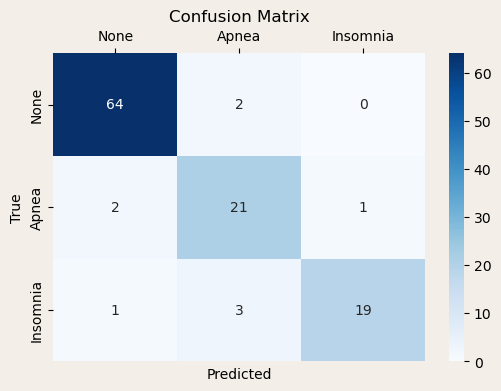

In [40]:
# Retrive best estimator from previous grid search
pipeline_dt = grid_search_dt.best_estimator_

pipeline_dt.fit(X_train, y_train)

# Generate prediction and show classification report
y_pred = pipeline_dt.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Cross validated and Test F1 score have both improved 4-5% following pre-pruning hyperparameter tuning methods.</li> 
    <li>Train has dropped as expected, and now very little sign of overfitting.</li>
    <li>Confusion matrix shows much better predictive ability for true Apnea Samples (Apnea recall and Insomnia precision are higher) and slight improvement for Apnea's precision and Insomnia's recall, although this is still trailing behind.</li>
</ul>
</div>


In [38]:
# Save baseline pipeline to file  
settings.save_pipeline("best_decision_tree_classification_pipeline.pkl", pipeline_dt)

*Post pruning*

In [39]:
pipeline_dt = settings.get_saved_pipeline("best_decision_tree_classification_pipeline.pkl")

# set up param grid
param_grid_dt = {
    'decision_tree_classification__ccp_alpha': np.linspace(0,10,11)
}

# Create and fit GridSearchCV object on train data
grid_search_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, scoring=custom_scorer, cv=cv_dt, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_dt, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,decision_tree_classification__ccp_alpha
0,0.0


---------------------
Using best parameters
---------------------
Train Score: 85.300 %
Mean CV Train Score: 83.100 % ( +- 5.600 % )
Test Score: 86.000 %


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Post pruning does not increase train CV accuracy nor test accuracy</li>
    <li>Post pruning was also run on the baseline model and did not increase any accuracy</li>
</ul>
</div>


*Exploring hyperparameter and SMOTE-NC for class imbalance*

In [41]:
pipeline_dt = settings.get_saved_pipeline("best_decision_tree_classification_pipeline.pkl")

# set up param grid
param_grid_dt = {
    'decision_tree_classification__class_weight': ["balanced"] 
}

# Create and fit GridSearchCV object on train data
grid_search_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, scoring=custom_scorer, cv=cv_dt, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_dt, X_train, y_train, X_test, y_test, scorer=base_scorer)


Best Parameters:


,decision_tree_classification__class_weight
0,balanced


---------------------
Using best parameters
---------------------
Train Score: 84.800 %
Mean CV Train Score: 79.300 % ( +- 5.800 % )
Test Score: 85.400 %


In [42]:
# instantiate SMOTENC object with categorical indicies of transformed X_train dataset
categorical_features = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)

# Proving smote object works using the X array transformed by column_trans
from collections import Counter
smote_x, smote_y = smote_nc.fit_resample(transformed_X_train_df, y_train)
print(f"Original class counts: {Counter(y_train)}")
print(f"New class counts: {Counter(smote_y)}")

Original class counts: Counter({0: 153, 2: 54, 1: 54})
New class counts: Counter({2: 153, 1: 153, 0: 153})


In [43]:
# Create a column transformer for ohe and scaling
column_trans = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), X_train.select_dtypes(include=['object']).columns)
    ],
    remainder='passthrough')

transformed_X_train_array = column_trans.fit_transform(X_train)
transformed_X_test_array = column_trans.transform(X_test)

# Convert to df as a sense check. Use only for interpretibility before using for pipeline. 
transformed_X_train_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_train_array)
transformed_X_test_df = settings.convert_transformed_features_to_df(column_trans, transformed_X_test_array)

# Check ohe and scaled datasets
# display("train: check for dummy encoded columns and scaled values (mean 0 and std 1)",transformed_X_train_df.shape, transformed_X_train_df.describe().loc[["mean", "std"],:])
# display("test: check for same dummy encoded columns and scaled values (mean close to 0 and std close to 1)",transformed_X_test_df.shape, transformed_X_test_df.describe().loc[["mean", "std"],:])

In [51]:
# Set up pipeline using imblearn's Pipeline class (SMOTE not compatible with sklearn's Pipeline)
# Reuse model with tuned hyperparameters
steps = [('column_trans', column_trans), ('smote', smote_nc), ("decision_tree_classification", model_dt)]
pipeline_dt = Pipeline_imb(steps)

# run training cross validation on pipeline 
cv_scores = cross_val_score(pipeline_dt, X_train, y_train, scoring=custom_scorer, cv=cv_dt)

settings.cross_val_summary(pipeline_dt, cv_scores, X_train, y_train, X_test, y_test, scorer=base_scorer)


Train Score: 90.100 %
Mean CV Train Score: 80.3100 % ( +- 6.100 % )
Test Score: 80.400 %


In [52]:
# set up param grid
param_grid_dt = {
    'decision_tree_classification__splitter': ["best", "random"], 
    'decision_tree_classification__max_depth': [None, 3, 5, 7],
    'decision_tree_classification__min_samples_split': [2, 5, 10],
    'decision_tree_classification__min_samples_leaf': [1, 5, 10],
    'decision_tree_classification__max_leaf_nodes': [None, 5, 10],
}

# Create and fit GridSearchCV object on train data
grid_search_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, scoring=custom_scorer, cv=cv_dt, n_jobs=-1)
grid_search_dt.fit(X_train, y_train)

settings.hyperparam_tune_summary(grid_search_dt, X_train, y_train, X_test, y_test, scorer=base_scorer)

Best Parameters:


,decision_tree_classification__max_depth,decision_tree_classification__max_leaf_nodes,decision_tree_classification__min_samples_leaf,decision_tree_classification__min_samples_split,decision_tree_classification__splitter
0,7,None,1,5,random


---------------------
Using best parameters
---------------------
Train Score: 88.300 %
Mean CV Train Score: 83.600 % ( +- 5.400 % )
Test Score: 89.600 %



Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97        66
           1       0.88      0.88      0.88        24
           2       0.88      0.96      0.92        23

    accuracy                           0.94       113
   macro avg       0.91      0.93      0.92       113
weighted avg       0.94      0.94      0.94       113



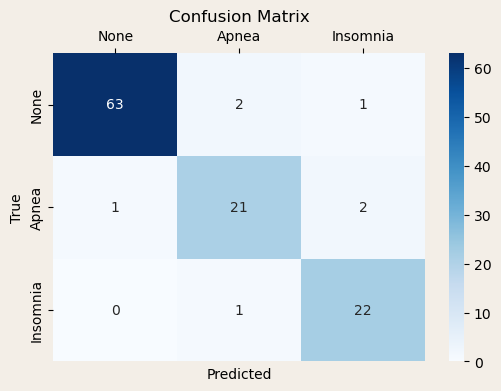

In [53]:
# Retrive best estimator from previous grid search
pipeline_dt = grid_search_dt.best_estimator_

pipeline_dt.fit(X_train, y_train)

# Generate prediction and show classification report
y_pred = pipeline_dt.predict(X_test)
class_report = classification_report(y_test, y_pred)
print("\nClassification Report:\n", class_report)

# Generate confusion matrix
class_labels = ["None","Apnea","Insomnia"]
conf_matrix = confusion_matrix(y_test, y_pred)

settings.plot_conf_matrix(class_labels, conf_matrix)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left; max-width: 1050px; margin: 0 auto; color: #444444;">

<h3 align="left"><font color='#DEB887'>💡 Insights:</font></h3>

<ul>
    <li>Using class_imbalance doesn't result in improvement in cv or test scores</li>
    <li>Adding smote to the pipeline has improved the cross validated F1 score and resulted in a large improvement in test score.</li>
    <li>High overall separation of positive classes with the lower precision or recall in Apnea and Insomnia at 88%.</li>
</ul>
</div>


In [54]:
# Save baseline pipeline to file  
settings.save_pipeline("best_decision_tree_classification_pipeline.pkl", pipeline_dt)

*Review metrics for hypertuned model*

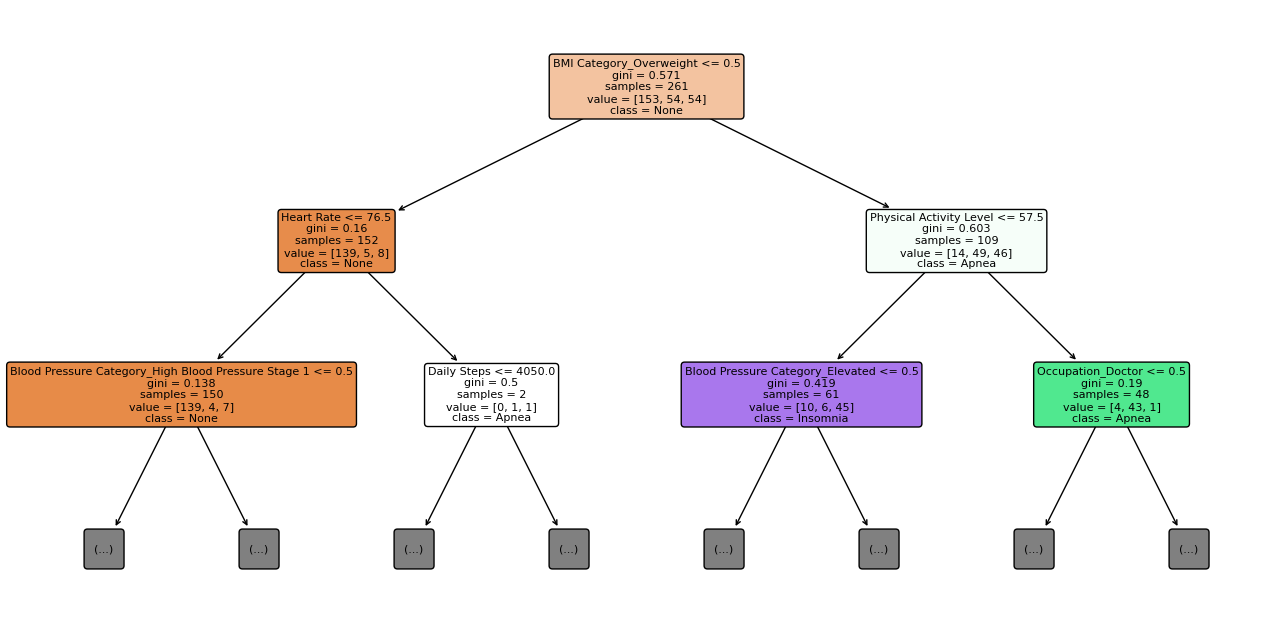

In [16]:
import matplotlib.pyplot as plt
from sklearn import tree

feature_names = transformed_X_train_df.columns
class_names = ["None", "Apnea", "Insomnia"]

# Create a larger figure for the plot
plt.figure(figsize=(16, 8))  # Adjust the width and height as needed

# Plot the decision tree
tree.plot_tree(model_dt, max_depth=2, feature_names=feature_names, class_names=class_names,
               filled=True, rounded=True, fontsize=8)  # Adjust fontsize as needed

# Show the plot
plt.show()


                             Feature  Importance
10               BMI Category_Normal    0.395834
6                   Occupation_Nurse    0.323723
21                        Heart Rate    0.109300
19           Physical Activity Level    0.039418
12  Blood Pressure Category_Elevated    0.038049


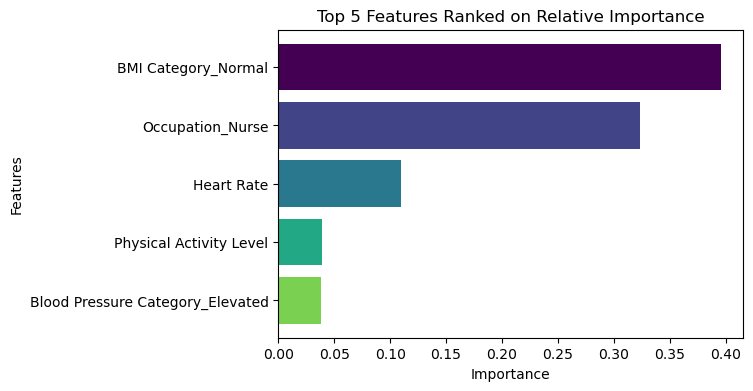

In [22]:
pipeline_dt = settings.get_saved_pipeline("best_decision_tree_classification_pipeline.pkl")
model_dt = pipeline_dt.named_steps["decision_tree_classification"]

# Access feature importances
feature_importances = model_dt.feature_importances_

# Get feature names from your dataset (assuming they are in a list or array)
feature_names = np.array(feature_names)

# Create a DataFrame to display feature importances with corresponding names
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)[:5]
print(importance_df)

# Re sort for the barh plot
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Use a color map for the bars and set colours for plot areas
cmap = plt.get_cmap("viridis") # Specify colour scheme 
colours = cmap(np.linspace(0, 0.8, 5)) # generate array from colour scheme. Don't use lightest colours
colours = colours[::-1]

# Plot the grouped bar chart
fig, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'hspace': 0.8})#, facecolor="#F3EEE7")
ax.barh(importance_df.Feature, importance_df.Importance, color=colours)
ax.set_xlabel("Importance")
ax.set_ylabel("Features")
ax.set_title("Top 5 Features Ranked on Relative Importance")

plt.savefig(r"images\feature_importance.png", bbox_inches='tight')
plt.show()